Loading detector interval data...
Processing 125 XML files...
Data saved to /content/drive/MyDrive/Data/Detector Data/DataSet Research 3-7/DataSet Research 3-7/Data/processed_detector_data.csv
hack_target
0    1900776
1     262224
Name: count, dtype: int64
Number of unique simulations: 114
X_array shape: (81738, 5, 553), dtype: float32
y_array shape: (81738,), dtype: int32
X_seq_scaled shape after permute: (81738, 553, 5)
X_reduced shape after PCA and permute: (81738, 200, 5)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.4228, Val Loss: 0.3913, Train Acc: 0.8801, Val Acc: 0.8902
Epoch [2/200], Train Loss: 0.3612, Val Loss: 0.3627, Train Acc: 0.8944, Val Acc: 0.8952
Epoch [3/200], Train Loss: 0.3234, Val Loss: 0.3501, Train Acc: 0.9010, Val Acc: 0.8978
Epoch [4/200], Train Loss: 0.2904, Val Loss: 0.3253, Train Acc: 0.9087, Val Acc: 0.8989
Epoch [5/200], Train Loss: 0.2602, Val Loss: 0.3443, Train Acc: 0.9165, Val Acc: 0.8975
Epoch [6/200], Train Loss: 0.2297, Val Loss: 0.3191, Train Acc: 0.9238, Val Acc: 0.8910
Epoch [7/200], Train Loss: 0.2067, Val Loss: 0.3313, Train Acc: 0.9305, Val Acc: 0.8864
Epoch [8/200], Train Loss: 0.1808, Val Loss: 0.4176, Train Acc: 0.9376, Val Acc: 0.8928
Epoch [9/200], Train Loss: 0.1622, Val Loss: 0.4036, Train Acc: 0.9449, Val Acc: 0.8865
Epoch [10/200], Train Loss: 0.1472, Val Loss: 0.3977, Train Acc: 0.9496, Val Acc: 0.8804
Epoch [11/200], Train Loss: 0.1281, Val Loss: 0.4332, Train Acc: 0.9565, Val Acc: 0.8815
Epoch [12/200], Train Loss: 0.

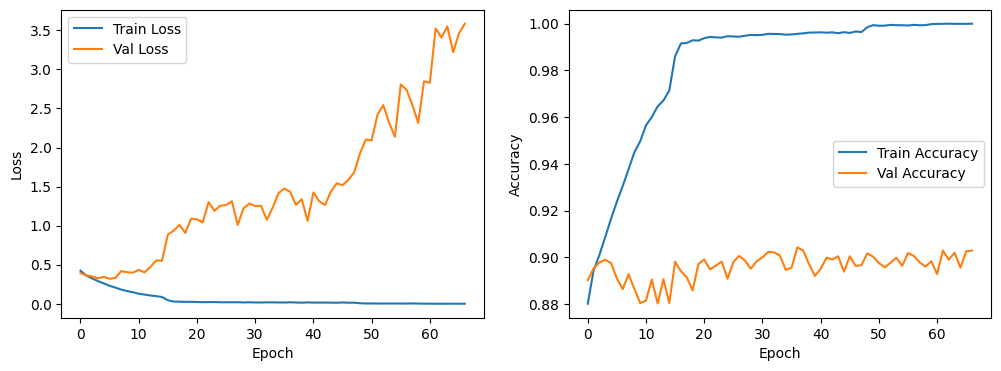

Test Accuracy: 90.23%
Precision: 0.8965
Recall: 0.9023
Confusion Matrix:
[[13560   628]
 [  969  1191]]
Saved predictions to '1d_cnn_predictions.csv'
Number of misclassified samples: 1597
Sample index 5: 0 out of 200 features shift prediction to correct label.
Sample index 12: 0 out of 200 features shift prediction to correct label.
Sample index 28: 0 out of 200 features shift prediction to correct label.
Sample index 31: 0 out of 200 features shift prediction to correct label.
Sample index 35: 1 out of 200 features shift prediction to correct label.
Sample index 38: 0 out of 200 features shift prediction to correct label.
Sample index 74: 0 out of 200 features shift prediction to correct label.
Sample index 91: 0 out of 200 features shift prediction to correct label.
Sample index 101: 0 out of 200 features shift prediction to correct label.
Sample index 118: 0 out of 200 features shift prediction to correct label.
Sample index 121: 0 out of 200 features shift prediction to correct lab

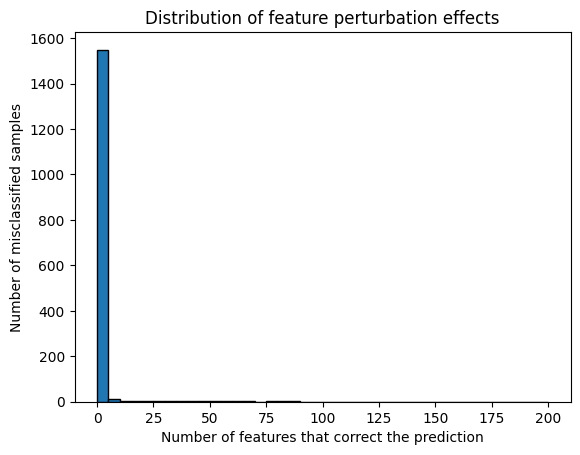

In [8]:
import gc
import os
import re
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.checkpoint as checkpoint
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import xml.etree.ElementTree as ET


def parse_filename(file_name: str) -> Dict[str, Optional[int]]:
    """Parse filename to extract structured metadata.

    Expected formats:
    - detector_data_HACKCLASS_INSTANCE_SEED_LIGHT_FIRSTHACK_SECONDHACK_DURATION.xml
    - detector_data_busy_CLASSIFICATION_INSTANCE_SEED.xml
    - detector_data_c_INSTANCE_SEED.xml

    Args:
        file_name: Name of the XML file.

    Returns:
        Dictionary with extracted metadata.
    """
    pattern_standard = r'detector_data_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+)_(\d+).xml'
    pattern_busy = r'detector_data_busy_([\d.]+)_(\d+)_(\d+).xml'
    pattern_control = r'detector_data_c_(\d+)_(\d+).xml'

    match_standard = re.match(pattern_standard, file_name)
    match_busy = re.match(pattern_busy, file_name)
    match_control = re.match(pattern_control, file_name)

    if match_standard:
        return {
            'simulation_type': 'hack',
            'hack_classification': int(match_standard.group(1)),
            'instance_number': int(match_standard.group(2)),
            'random_seed': int(match_standard.group(3)),
            'light': int(match_standard.group(4)),
            'first_hack_time': int(match_standard.group(5)),
            'second_hack_time': int(match_standard.group(6)),
            'hack_duration': int(match_standard.group(7)),
        }
    elif match_busy:
        return {
            'simulation_type': 'busy',
            'hack_classification': 5,
            'instance_number': int(match_busy.group(2)),
            'random_seed': int(match_busy.group(3)),
            'light': None,
            'first_hack_time': 0,
            'second_hack_time': 0,
            'hack_duration': 0,
        }
    elif match_control:
        return {
            'simulation_type': 'control',
            'hack_classification': 6,
            'instance_number': int(match_control.group(1)),
            'random_seed': int(match_control.group(2)),
            'light': None,
            'first_hack_time': 0,
            'second_hack_time': 0,
            'hack_duration': 0,
        }
    return {
        'simulation_type': 'unknown',
        'hack_classification': None,
        'instance_number': None,
        'random_seed': None,
        'light': None,
        'first_hack_time': 0,
        'second_hack_time': 0,
        'hack_duration': 0,
    }


def load_detector_intervals(folder_path: str) -> pd.DataFrame:
    """Load XML files and extract interval data with metadata.

    Args:
        folder_path: Directory containing XML files.

    Returns:
        DataFrame with parsed interval data.
    """
    data_records = []
    all_columns = set()

    files = [
        f for f in os.listdir(folder_path)
        if f.startswith('detector_data') and f.endswith('.xml')
    ]

    if not files:
        print('No matching XML files found.')
        return pd.DataFrame()

    print(f'Processing {len(files)} XML files...')

    for file in files:
        file_path = os.path.join(folder_path, file)
        metadata = parse_filename(file)

        try:
            tree = ET.parse(file_path)
            root = tree.getroot()

            for interval in root.findall('.//interval'):
                record = {'file_name': file, **metadata}
                for attr, value in interval.attrib.items():
                    record[attr] = value
                    all_columns.add(attr)
                data_records.append(record)

        except Exception as e:
            print(f'Error parsing {file}: {e}')

    if not data_records:
        print('No interval data extracted.')
        return pd.DataFrame()

    df = pd.DataFrame(data_records)
    for col in all_columns:
        if col not in df.columns:
            df[col] = None

    return df


def create_hack_target(df: pd.DataFrame) -> pd.DataFrame:
    """Create a binary 'hack_target' column indicating if a hack occurred.

    Args:
        df: DataFrame with interval data.

    Returns:
        DataFrame with added 'hack_target' column.
    """
    hack_targets = []

    for _, row in df.iterrows():
        first_hack_start = row['first_hack_time']
        first_hack_end = first_hack_start + row['hack_duration']
        second_hack_start = row['second_hack_time']
        second_hack_end = second_hack_start + row['hack_duration']

        is_hack = (
            (float(row['begin']) >= first_hack_start and
             float(row['begin']) <= first_hack_end) or
            (float(row['end']) >= first_hack_start and
             float(row['end']) <= first_hack_end) or
            (float(row['begin']) >= second_hack_start and
             float(row['begin']) <= second_hack_end) or
            (float(row['end']) >= second_hack_start and
             float(row['end']) <= second_hack_end)
        )
        hack_targets.append(1 if is_hack else 0)

    df['hack_target'] = hack_targets
    return df


def pivot_sensor_data(df: pd.DataFrame) -> pd.DataFrame:
    """Pivot sensor readings while preserving metadata like 'hack_target'.

    Args:
        df: DataFrame with sensor data.

    Returns:
        Pivoted DataFrame with sensor data organized by sensor ID.
    """
    unique_index = ['instance_number', 'random_seed', 'begin', 'end']
    group_index = unique_index + ['id']
    extra_cols = unique_index + ['hack_target']
    df_extra = df[extra_cols].drop_duplicates(subset=unique_index)

    sensor_columns = [
        'sampledSeconds', 'nVehEntered', 'nVehLeft', 'nVehSeen', 'meanSpeed',
        'meanTimeLoss', 'meanOccupancy', 'maxOccupancy',
        'meanMaxJamLengthInVehicles', 'meanMaxJamLengthInMeters',
        'maxJamLengthInVehicles', 'maxJamLengthInMeters',
        'jamLengthInVehiclesSum', 'jamLengthInMetersSum',
        'meanHaltingDuration', 'maxHaltingDuration', 'haltingDurationSum',
        'meanIntervalHaltingDuration', 'maxIntervalHaltingDuration',
        'intervalHaltingDurationSum', 'startedHalts', 'meanVehicleNumber',
        'maxVehicleNumber'
    ]

    for col in sensor_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_grouped = df.groupby(group_index).agg({
        'sampledSeconds': 'mean',
        'nVehEntered': 'sum',
        'nVehLeft': 'sum',
        'nVehSeen': 'sum',
        'meanSpeed': 'mean',
        'meanTimeLoss': 'mean',
        'meanOccupancy': 'mean',
        'maxOccupancy': 'max',
        'meanMaxJamLengthInVehicles': 'mean',
        'meanMaxJamLengthInMeters': 'mean',
        'maxJamLengthInVehicles': 'max',
        'maxJamLengthInMeters': 'max',
        'jamLengthInVehiclesSum': 'sum',
        'jamLengthInMetersSum': 'sum',
        'meanHaltingDuration': 'mean',
        'maxHaltingDuration': 'max',
        'haltingDurationSum': 'sum',
        'meanIntervalHaltingDuration': 'mean',
        'maxIntervalHaltingDuration': 'max',
        'intervalHaltingDurationSum': 'sum',
        'startedHalts': 'sum',
        'meanVehicleNumber': 'mean',
        'maxVehicleNumber': 'max'
    }).reset_index()

    df_pivoted = df_grouped.pivot(index=unique_index, columns='id',
                                  values=sensor_columns)
    df_pivoted.columns = [f'{sensor}_{sensor_id}'
                          for sensor, sensor_id in df_pivoted.columns]
    df_pivoted.reset_index(inplace=True)
    df_final = df_pivoted.merge(df_extra, on=unique_index, how='left')

    return df_final


def create_sequences(df: pd.DataFrame, seq_length: int = 5) -> tuple:
    """Create sequences for time-series modeling.

    Args:
        df: DataFrame with sensor data.
        seq_length: Length of each sequence.

    Returns:
        Tuple of (X, y) arrays for features and targets.
    """
    X, y = [], []
    grouped = df.groupby(['instance_number', 'random_seed'])

    for (instance, seed), group in grouped:
        group_sorted = group.sort_values('begin')
        feature_cols = [col for col in group_sorted.columns
                        if col not in ['instance_number', 'random_seed',
                                       'begin', 'hack_target']]
        features = group_sorted[feature_cols].apply(
            pd.to_numeric, errors='coerce').fillna(0).values
        targets = group_sorted['hack_target'].values

        for i in range(len(features) - seq_length + 1):
            X.append(features[i:i + seq_length])
            y.append(targets[i + seq_length - 1])

    X_array = np.array(X, dtype=np.float32)
    y_array = np.array(y, dtype=np.int32)
    print(f'X_array shape: {X_array.shape}, dtype: {X_array.dtype}')
    print(f'y_array shape: {y_array.shape}, dtype: {y_array.dtype}')
    return X_array, y_array


class CNN1D(nn.Module):
    """1D Convolutional Neural Network for sequence classification."""
    def __init__(self, input_channels: int, seq_length: int, num_classes: int = 2):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128,
                               kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        dummy_input = torch.zeros(1, input_channels, seq_length, dtype=torch.float32)
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        x = self.pool(torch.relu(self.conv2(x)))
        self.flat_size = x.numel()
        self.fc1 = nn.Linear(self.flat_size, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = checkpoint.checkpoint(
            lambda inp: self.pool(torch.relu(self.conv1(inp))), x,
            use_reentrant=False)
        x = checkpoint.checkpoint(
            lambda inp: self.pool(torch.relu(self.conv2(inp))), x,
            use_reentrant=False)
        x = x.view(x.size(0), -1)
        x = checkpoint.checkpoint(
            lambda inp: torch.relu(self.fc1(inp)), x, use_reentrant=False)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def perturb_sample(model: nn.Module, sample: torch.Tensor, feature_idx: int,
                   perturbation: float = 0.1, device: str = 'cpu') -> tuple:
    """Perturb a sample's feature and observe prediction change.

    Args:
        model: Trained model.
        sample: Tensor of shape [features, timesteps].
        feature_idx: Index of feature to perturb.
        perturbation: Fractional change (e.g., 0.1 for +10%).
        device: Device to run the model on.

    Returns:
        Tuple of (original prediction, perturbed prediction).
    """
    model.eval()
    sample = sample.to(device)
    with torch.no_grad():
        output_orig = model(sample.unsqueeze(0))
        orig_pred = torch.argmax(torch.softmax(output_orig, dim=1), dim=1).item()

    sample_cf = sample.clone()
    sample_cf[feature_idx, :] *= (1 + perturbation)
    with torch.no_grad():
        output_cf = model(sample_cf.unsqueeze(0))
        pert_pred = torch.argmax(torch.softmax(output_cf, dim=1), dim=1).item()

    return orig_pred, pert_pred


def main():
    """Main function to process data and train the model."""
    folder_path = ('/content/drive/MyDrive/Data/Detector Data/'
                   'DataSet Research 3-7/DataSet Research 3-7/Data')
    print('Loading detector interval data...')
    df = load_detector_intervals(folder_path)

    if df.empty:
        print('No data was processed.')
        return

    output_path = os.path.join(folder_path, 'processed_detector_data.csv')
    df.to_csv(output_path, index=False)
    print(f'Data saved to {output_path}')

    df = create_hack_target(df)
    print(df['hack_target'].value_counts())
    df.drop(columns=['simulation_type'], inplace=True)
    df_pivoted = pivot_sensor_data(df)
    df_cleaned = df_pivoted

    print(f'Number of unique simulations: '
          f'{df_cleaned.groupby(["instance_number", "random_seed"]).ngroup().nunique()}')

    seq_length = 5
    X_seq, y_seq = create_sequences(df_cleaned, seq_length)

    scaler = StandardScaler()
    X_seq_reshaped = X_seq.reshape(-1, X_seq.shape[-1])
    X_seq_scaled = scaler.fit_transform(X_seq_reshaped)
    X_seq_scaled = X_seq_scaled.reshape(X_seq.shape)
    X_seq_scaled = np.transpose(X_seq_scaled, (0, 2, 1))
    print(f'X_seq_scaled shape after permute: {X_seq_scaled.shape}')

    num_samples, orig_features, timesteps = X_seq_scaled.shape
    X_flat = X_seq_scaled.reshape(num_samples * timesteps, orig_features)
    n_components = 200
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_flat)
    X_pca_reshaped = X_pca.reshape(num_samples, timesteps, n_components)
    X_reduced = np.transpose(X_pca_reshaped, (0, 2, 1))
    print(f'X_reduced shape after PCA and permute: {X_reduced.shape}')

    del X_seq, X_seq_reshaped, X_seq_scaled, X_flat, X_pca, X_pca_reshaped
    gc.collect()

    X_temp, X_test, y_temp, y_test = train_test_split(
        X_reduced, y_seq, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    batch_size = 8
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, pin_memory=True)

    # Initialize model
    input_channels = n_components
    model = CNN1D(input_channels=input_channels, seq_length=seq_length)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    class_weights = torch.tensor([0.5, 1.0], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True)

    num_epochs = 200
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_acc = 0.0
    counter = 0
    patience = 30

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(batch_y.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_acc)

        model.eval()
        total_val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(batch_y.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), 'best_1d_cnn_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        scheduler.step(val_acc)
        torch.cuda.empty_cache()
        gc.collect()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load('best_1d_cnn_model.pt'))
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy_val = accuracy_score(all_labels, all_preds)
    precision_val = precision_score(all_labels, all_preds, average='weighted')
    recall_val = recall_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Test Accuracy: {accuracy_val * 100:.2f}%')
    print(f'Precision: {precision_val:.4f}')
    print(f'Recall: {recall_val:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    results = pd.DataFrame({
        'true_label': all_labels,
        'predicted_label': all_preds
    })
    results.to_csv('1d_cnn_predictions.csv', index=False)
    print("Saved predictions to '1d_cnn_predictions.csv'")

    misclassified_indices = [i for i, (t, p) in enumerate(zip(all_labels, all_preds))
                             if t != p]
    print(f'Number of misclassified samples: {len(misclassified_indices)}')

    shift_counts = []
    for idx in misclassified_indices:
        sample = X_test_tensor[idx]
        true_label = y_test_tensor[idx].item()
        count_shift = 0
        for feature in range(n_components):
            orig, pert = perturb_sample(model, sample, feature,
                                        perturbation=0.1, device=device)
            if orig != true_label and pert == true_label:
                count_shift += 1
        print(f'Sample index {idx}: {count_shift} out of {n_components} '
              f'features shift prediction to correct label.')
        shift_counts.append(count_shift)

    average_shifts = np.mean(shift_counts)
    print(f'Average number of features (out of {n_components}) that shift '
          f'misclassified samples to the correct label: {average_shifts:.2f}')

    plt.hist(shift_counts, bins=range(0, n_components + 1, 5), edgecolor='k')
    plt.xlabel('Number of features that correct the prediction')
    plt.ylabel('Number of misclassified samples')
    plt.title('Distribution of feature perturbation effects')
    plt.show()


if __name__ == '__main__':
    main()